In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap
import pathlib
import h5py
import sys

task = "sim_transfer_cube_scripted"
file_name = "keypose_cache-min_5.hdf5"
proj_dir = pathlib.Path("~/bimanual/Diffusion-Policy").expanduser()
dataset_dir = proj_dir / "data" / "aloha" / "datasets" / task
dataset_path = str(dataset_dir / file_name)

sys.path.append(str(proj_dir))

/home/yudongjie/miniforge3/envs/robodiff2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Keyposes in keypose dataset

In [2]:
with h5py.File(dataset_path, "r+") as demo:
    current_keypose = demo["qpos"][:]
    next_keypose = demo["next_keypose"][:]

df_current_keypose = pd.DataFrame(current_keypose)
df_next_keypose = pd.DataFrame(next_keypose)

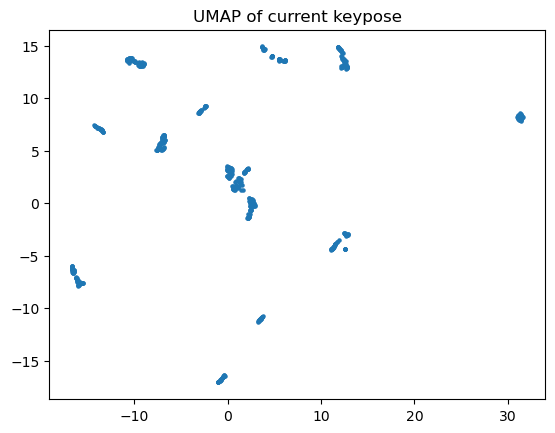

In [3]:
model = umap.UMAP(n_components=2)
res = model.fit(df_current_keypose)
plt.scatter(res.embedding_[:, 0], res.embedding_[:, 1], s=5)
plt.title("UMAP of current keypose")
plt.show()

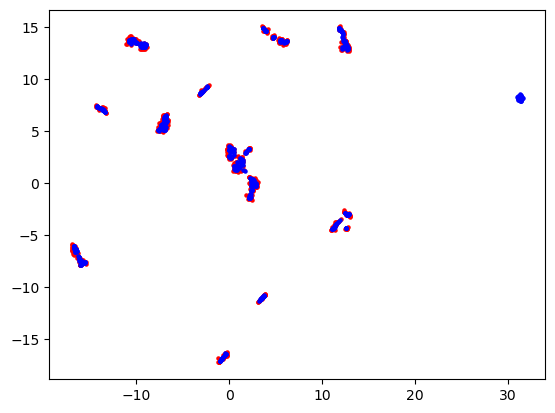

In [4]:
testing_emb = res.transform(df_next_keypose)
plt.scatter(testing_emb[:, 0], testing_emb[:, 1], s=5, c="r")
plt.scatter(res.embedding_[:, 0], res.embedding_[:, 1], s=5, c="b")
plt.show()

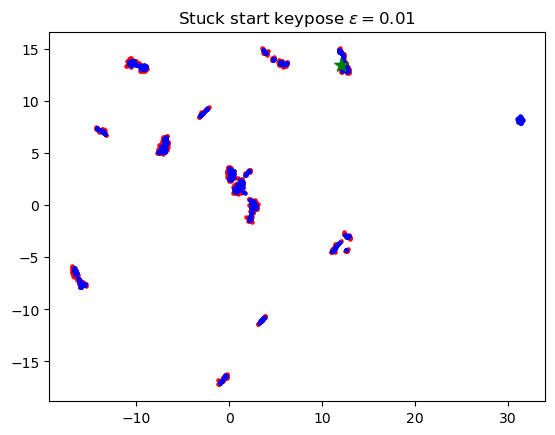

In [6]:
stuck_start_keypose = np.np.array(
    [[
        -3.8173e-04, -1.5859e+00,  1.2139e+00, -5.8201e-04,  3.9169e-01,
        1.8825e-01,  1.0068e-01,  2.3453e-03, -1.5710e+00,  1.1885e+00,
        -7.2245e-03,  5.2287e-01,  4.5115e-03,  1.0999e-01
    ]]
)
stuck_start_emb = res.transform(stuck_start_keypose)
plt.scatter(testing_emb[:, 0], testing_emb[:, 1], s=5, c="r")
plt.scatter(res.embedding_[:, 0], res.embedding_[:, 1], s=5, c="b")
plt.scatter(stuck_start_emb[:, 0], stuck_start_emb[:, 1], s=100, c="g", marker="*")
plt.title(r"Stuck start keypose $\epsilon=0.01$")
plt.show()

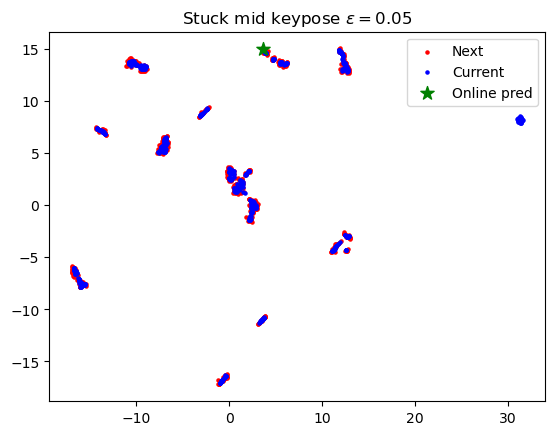

In [7]:
stuck_mid_keypose = np.np.array(
    [
        [
            -0.0089, -0.1214,  0.8521, -0.0155, -0.7285,  1.6265,  0.9717, -0.0914,
            0.0714,  0.1433,  0.1236,  0.8782, -0.1847,  0.5528
        ],
        
    ]
)

stuck_mid_emb = res.transform(stuck_mid_keypose)
plt.scatter(testing_emb[:, 0], testing_emb[:, 1], s=5, c="r", label="Next")
plt.scatter(res.embedding_[:, 0], res.embedding_[:, 1], s=5, c="b", label="Current")
plt.scatter(stuck_mid_emb[:, 0], stuck_mid_emb[:, 1], s=100, c="g", marker="*", label="Online pred")
plt.title(r"Stuck mid keypose $\epsilon=0.05$")
plt.legend()
plt.show()

## Repeated keyposes in trajectory dataset

In [31]:
import zarr
import os

from diffusion_policy.dataset.trajectory_aloha_dataset import ReplayBufferWithKeypose
from diffusion_policy.common.sampler_with_keypose import create_indices, get_val_mask

# load the trajectory replay buffer
cache_zarr_path = str(dataset_dir / "trajectory_cache-min_5.zarr.zip")
if not os.path.exists(cache_zarr_path):
    print("Cache does not exist.")
else:
    with zarr.ZipStore(cache_zarr_path, mode="r") as zip_store:
        replay_buffer = ReplayBufferWithKeypose.copy_from_store(
            src_store=zip_store, store=zarr.MemoryStore()
        )

traj_ends = replay_buffer.keyposes[:]
val_mask = get_val_mask(replay_buffer.n_subtrajs, 0.1, seed=42)
train_mask = ~val_mask
indices = create_indices(
    traj_ends=traj_ends, sequence_length=10, traj_mask=train_mask,
    pad_before=1, pad_after=7
)

target_keyposes = replay_buffer["qpos"][()][indices[:, -1]]

(17458, 14)


In [41]:
target_emb = res.transform(target_keyposes)

In [49]:
ep0_emb = res.transform(
    np.np.array(
      [[ 0.00000000e+00, -9.59999979e-01,  1.15999997e+00,
         0.00000000e+00, -3.00000012e-01,  0.00000000e+00,
         9.98483300e-02,  0.00000000e+00, -9.59999979e-01,
         1.15999997e+00,  0.00000000e+00, -3.00000012e-01,
         0.00000000e+00,  9.98483300e-02],
       [-4.18796844e-04, -1.57677877e+00,  1.21215153e+00,
        -6.39692298e-04,  3.84062827e-01,  1.96470544e-01,
         1.05165474e-01, -7.74171785e-04, -1.55055988e+00,
         1.18952835e+00,  7.80810183e-03,  5.06588578e-01,
        -1.01544522e-02,  1.16110608e-01],
       [-7.63201201e-03, -4.44880277e-01,  1.08466089e+00,
        -1.57264695e-02, -6.39191985e-01,  1.58244812e+00,
         9.31018174e-01,  2.39574343e-01,  1.82979003e-01,
         4.91335571e-01, -3.13430250e-01,  4.00611252e-01,
         5.04127979e-01,  9.72440779e-01],
       [-8.80413502e-03, -3.93781662e-01,  1.05693614e+00,
        -1.67510230e-02, -6.61013305e-01,  1.58302665e+00,
         9.31416929e-01,  2.39594504e-01,  2.14930460e-01,
         4.80049640e-01, -3.22855175e-01,  3.85118693e-01,
         5.11515141e-01,  8.39805782e-01],
       [-9.55949631e-03, -3.40946227e-01,  1.02470040e+00,
        -1.71329398e-02, -6.80139601e-01,  1.58312666e+00,
         9.31522667e-01,  2.39715829e-01,  2.30231598e-01,
         4.70423728e-01, -3.21303576e-01,  3.83222759e-01,
         5.12226760e-01,  6.12306237e-01],
       [-8.16947781e-03, -9.37132537e-02,  8.09525371e-01,
        -1.38540296e-02, -7.08362162e-01,  1.58046794e+00,
         9.31583822e-01,  1.97219825e-03,  4.84492211e-03,
        -3.32381856e-03, -3.19195655e-03,  1.04839945e+00,
        -3.18708131e-04,  6.05949104e-01],
       [-7.35918200e-03, -3.30658481e-02,  7.42893815e-01,
        -1.60893984e-02, -7.02198088e-01,  1.57911909e+00,
         9.28642154e-01,  2.86043301e-04,  2.89599802e-02,
        -2.85040308e-02,  8.96277896e-04,  1.05992019e+00,
        -5.31723839e-04,  6.12659693e-01],
       [-7.06880819e-03, -1.91273354e-02,  7.35166550e-01,
        -1.61748622e-02, -7.07058668e-01,  1.57924104e+00,
         8.80682945e-01,  3.92274174e-04,  3.00861802e-02,
        -2.92713232e-02,  1.87659182e-03,  1.06477869e+00,
        -4.80761926e-04,  6.32608950e-01],
       [-6.98640151e-03, -3.15882033e-03,  7.27320910e-01,
        -1.35436449e-02, -7.09612846e-01,  1.57952070e+00,
         5.46845675e-01,  2.53685896e-04,  3.21853571e-02,
        -3.25992517e-02, -2.56665656e-03,  1.05830693e+00,
         1.38532458e-04,  7.40114152e-01],
       [-3.37936264e-03, -3.09477717e-01,  1.10205567e+00,
        -5.77990338e-03, -7.69673228e-01,  2.70997873e-03,
         6.03099763e-01,  2.94556958e-05, -2.72598296e-01,
         2.97588587e-01, -2.69980798e-03,  1.04078364e+00,
         4.77941539e-05,  9.74746943e-01],
       [-2.70836242e-03, -3.30257088e-01,  1.10491049e+00,
        -5.15293237e-03, -7.53368676e-01,  2.22658971e-03,
         6.04138136e-01,  3.03613251e-05, -2.83039242e-01,
         3.05669069e-01, -2.69997143e-03,  1.03951991e+00,
         4.83844487e-05,  9.74746883e-01],
       [-1.61990116e-03, -3.62760425e-01,  1.10970211e+00,
        -4.05335613e-03, -7.28349328e-01,  1.38479273e-03,
         6.04820132e-01,  3.12308657e-05, -2.93733716e-01,
         3.13734442e-01, -2.70109414e-03,  1.03835356e+00,
         4.89584163e-05,  9.74746823e-01]], dtype=np.float32)
)

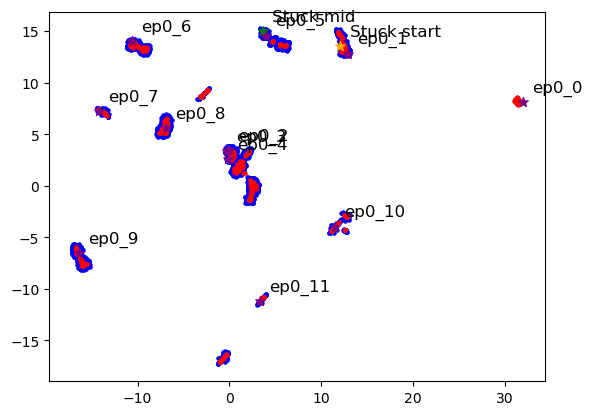

In [65]:
plt.scatter(target_emb[:, 0], target_emb[:, 1], s=5, c="b", label="Target")
plt.scatter(res.embedding_[:, 0], res.embedding_[:, 1], s=5, c="r", label="Next")
# plot the stuck start and mid keyposes, with text annotation

plt.scatter(stuck_start_emb[:, 0], stuck_start_emb[:, 1], s=50, c="orange", marker="*")
plt.text(stuck_start_emb[0, 0]+1, stuck_start_emb[0, 1]+1, "Stuck start", fontsize=12)

plt.scatter(stuck_mid_emb[:, 0], stuck_mid_emb[:, 1], s=50, c="g", marker="*", label="Stuck mid")
plt.text(stuck_mid_emb[0, 0]+1, stuck_mid_emb[0, 1]+1, "Stuck mid", fontsize=12)


for i in range(len(ep0_emb)):
    plt.scatter(ep0_emb[i, 0], ep0_emb[i, 1], s=50, c="purple", marker="*", label="ep0")
    plt.text(ep0_emb[i, 0]+1, ep0_emb[i, 1]+1, f"ep0_{i}", fontsize=12)

plt.show()

In [55]:
qpos_after_stuck = np.concatenate(
    [
        np.array([[-0.00946353, -0.35086915,  1.0337013 , -0.01712884, -0.679622  ,
         1.5831455 ,  0.9315066 , -0.30240962,  0.1267366 ,  0.62888485,
         0.4533076 ,  0.35433877, -0.6912763 ,  0.6727288 ]],
      dtype=np.float32),
np.array([[-0.00973763, -0.31674787,  1.0112703 , -0.0171134 , -0.69147193,
         1.5831478 ,  0.93159515, -0.30140054,  0.13803582,  0.6182642 ,
         0.45185667,  0.35132307, -0.6929573 ,  0.6405357 ]],
      dtype=np.float32),
np.array([[-0.00982905, -0.29127848,  0.99581295, -0.01711163, -0.6977183 ,
         1.5831485 ,  0.9315069 , -0.29930884,  0.1469882 ,  0.60770404,
         0.4428779 ,  0.35225344, -0.6832887 ,  0.6250802 ]],
      dtype=np.float32),
np.array([[-0.00984337, -0.2627149 ,  0.97336847, -0.01710576, -0.70449317,
         1.5831538 ,  0.9317511 , -0.29741326,  0.14937721,  0.5921669 ,
         0.40993026,  0.3711443 , -0.64082456,  0.6205662 ]],
      dtype=np.float32),
np.array([[-0.00971628, -0.23897934,  0.95254135, -0.01653275, -0.7063223 ,
         1.5831461 ,  0.9316717 , -0.27644223,  0.08427823,  0.5031651 ,
         0.25262353,  0.5166546 , -0.4296626 ,  0.607244  ]],
      dtype=np.float32),
np.array([[-0.00954397, -0.21767946,  0.93456286, -0.0162536 , -0.709647  ,
         1.5831459 ,  0.93165034, -0.22876528,  0.00581996,  0.40948227,
         0.15016492,  0.6758077 , -0.27453852,  0.60350376]],
      dtype=np.float32),
np.array([[-0.00936227, -0.19609666,  0.9158945 , -0.01603692, -0.7129439 ,
         1.5831448 ,  0.9316685 , -0.1689788 , -0.05123498,  0.30315274,
         0.08604803,  0.8288081 , -0.1616252 ,  0.60370517]],
      dtype=np.float32),
np.array([[-0.00916217, -0.17620315,  0.8975423 , -0.0156395 , -0.7138625 ,
         1.5831411 ,  0.93157583, -0.1075335 , -0.08993382,  0.1868135 ,
         0.0428786 ,  0.9713904 , -0.07911476,  0.60509473]],
      dtype=np.float32),
np.array([[-0.00895622, -0.15690526,  0.878465  , -0.01527032, -0.7146613 ,
         1.5831325 ,  0.9316265 , -0.05728609, -0.09848253,  0.12264071,
         0.0147889 ,  1.0326451 , -0.02693588,  0.60560787]],
      dtype=np.float32),
np.array([[-0.00873856, -0.13630007,  0.8578011 , -0.01490383, -0.71505404,
         1.5831223 ,  0.93182474, -0.02686402, -0.06942858,  0.07847113,
         0.00427614,  1.0361063 , -0.01041937,  0.6064513 ]],
      dtype=np.float32),
np.array([[-8.5096667e-03, -1.1712855e-01,  8.3949691e-01, -1.4485782e-02,
        -7.1395916e-01,  1.5831428e+00,  9.3214667e-01, -1.1922766e-02,
        -2.8952416e-02,  3.4098458e-02,  9.4377046e-04,  1.0411785e+00,
        -4.8449072e-03,  6.0640031e-01]], dtype=np.float32),
np.array([[-8.2900804e-03, -9.9024355e-02,  8.2174152e-01, -1.4171047e-02,
        -7.1190089e-01,  1.5831591e+00,  9.3228018e-01, -5.8473889e-03,
        -3.4826528e-03,  1.0875285e-02, -7.0554367e-04,  1.0468757e+00,
        -3.1187905e-03,  6.0615218e-01]], dtype=np.float32),
np.array([[-0.0081769 , -0.09226782,  0.8219453 , -0.01441551, -0.7116817 ,
         1.5831802 ,  0.93186057, -0.00531344,  0.00996584,  0.00553812,
         0.00252805,  1.0465257 , -0.00968695,  0.6063741 ]],
      dtype=np.float32),
np.array([[-0.00814816, -0.09093542,  0.82343733, -0.0146408 , -0.71241444,
         1.5831788 ,  0.9317932 , -0.00673093,  0.0170882 ,  0.00564754,
         0.00632895,  1.0420072 , -0.0152809 ,  0.6063966 ]],
      dtype=np.float32),
np.array([[-0.0081152 , -0.0880268 ,  0.8197608 , -0.01457706, -0.7121581 ,
         1.5831785 ,  0.93199384, -0.00762684,  0.01788744,  0.00426856,
         0.00606686,  1.0434012 , -0.01579958,  0.6062319 ]],
      dtype=np.float32),
np.array([[-0.00807324, -0.08427046,  0.8151182 , -0.01446656, -0.711603  ,
         1.5831784 ,  0.932047  , -0.00754469,  0.01726934,  0.00230786,
         0.00580957,  1.0457113 , -0.01362341,  0.6058187 ]],
      dtype=np.float32),
np.array([[-8.0319308e-03, -8.0726855e-02,  8.1091243e-01, -1.4364455e-02,
        -7.1102965e-01,  1.5831784e+00,  9.3204248e-01, -6.8469686e-03,
         1.6773485e-02,  3.8110567e-04,  3.7665125e-03,  1.0476859e+00,
        -1.1604262e-02,  6.0599941e-01]], dtype=np.float32),
np.array([[-7.9881577e-03, -7.6733567e-02,  8.0612874e-01, -1.4269329e-02,
        -7.1045321e-01,  1.5831789e+00,  9.3207216e-01, -6.0344101e-03,
         1.6832896e-02, -1.5462469e-03,  3.3547066e-03,  1.0491138e+00,
        -9.5115127e-03,  6.0582280e-01]], dtype=np.float32),
np.array([[-0.00794535, -0.07273628,  0.80155706, -0.01418737, -0.7099327 ,
         1.5831798 ,  0.9320763 , -0.00522715,  0.01746601, -0.00362057,
         0.00221416,  1.0503393 , -0.00790005,  0.60584253]],
      dtype=np.float32),
np.array([[-7.9011722e-03, -6.8457440e-02,  7.9672813e-01, -1.4114727e-02,
        -7.0943254e-01,  1.5831811e+00,  9.3209100e-01, -4.5824712e-03,
         1.8617267e-02, -5.8186869e-03,  1.4899810e-03,  1.0513364e+00,
        -6.7862831e-03,  6.0584486e-01]], dtype=np.float32),
np.array([[-7.8625390e-03, -6.4858042e-02,  7.9287243e-01, -1.4058606e-02,
        -7.0901644e-01,  1.5831815e+00,  9.3206537e-01, -4.0636417e-03,
         1.9797625e-02, -7.8084585e-03,  9.0913085e-04,  1.0522342e+00,
        -5.9317150e-03,  6.0585582e-01]], dtype=np.float32),
np.array([[-7.8250160e-03, -6.1294071e-02,  7.8878677e-01, -1.3996520e-02,
        -7.0857900e-01,  1.5831820e+00,  9.3208551e-01, -3.6301997e-03,
         2.0992212e-02, -9.8240525e-03,  4.8966147e-04,  1.0530199e+00,
        -5.2008103e-03,  6.0589695e-01]], dtype=np.float32),
np.array([[-7.7775023e-03, -5.6579228e-02,  7.8307116e-01, -1.3912682e-02,
        -7.0792830e-01,  1.5831828e+00,  9.3214899e-01, -3.2319413e-03,
         2.2564756e-02, -1.2559907e-02,  1.0421132e-04,  1.0540088e+00,
        -4.6738274e-03,  6.0542232e-01]], dtype=np.float32),
np.array([[-7.6934146e-03, -5.0610505e-02,  7.7563691e-01, -1.3315521e-02,
        -7.0698792e-01,  1.5832251e+00,  9.3254781e-01, -2.7834715e-03,
         2.4496926e-02, -1.6058505e-02,  3.0937459e-04,  1.0551792e+00,
        -3.9138561e-03,  6.0689968e-01]], dtype=np.float32),
np.array([[-7.5621665e-03, -4.2221878e-02,  7.6453775e-01, -1.3577706e-02,
        -7.0543790e-01,  1.5831562e+00,  9.3369049e-01, -2.3409913e-03,
         2.6865082e-02, -2.0875670e-02,  8.0001366e-04,  1.0565999e+00,
        -3.5471688e-03,  6.1019158e-01]], dtype=np.float32),
np.array([[-0.00740839, -0.03586992,  0.757142  , -0.0144866 , -0.70422333,
         1.5831041 ,  0.9366456 , -0.00194062,  0.02839481, -0.02367995,
         0.00201143,  1.0577203 , -0.00327901,  0.6158791 ]],
      dtype=np.float32),
np.array([[-0.00726269, -0.03034152,  0.7515522 , -0.01643322, -0.7046773 ,
         1.5828514 ,  0.9436215 , -0.00182932,  0.0307105 , -0.02737339,
         0.00349412,  1.0596591 , -0.00387522,  0.6204965 ]],
      dtype=np.float32),
np.array([[-0.00718785, -0.02860314,  0.7510509 , -0.01713145, -0.7044797 ,
         1.5827411 ,  0.9409777 , -0.00166129,  0.03175792, -0.02859143,
         0.00358655,  1.0602077 , -0.00343313,  0.62347656]],
      dtype=np.float32),
np.array([[-7.1631856e-03, -2.8165355e-02,  7.5115693e-01, -1.6416010e-02,
        -7.0432013e-01,  1.5828493e+00,  9.3860406e-01, -1.4198924e-03,
         3.1952981e-02, -2.8748851e-02,  2.7480843e-03,  1.0608562e+00,
        -2.5110752e-03,  6.2514353e-01]], dtype=np.float32),
np.array([[-7.1587921e-03, -2.7947435e-02,  7.5106555e-01, -1.6231798e-02,
        -7.0429236e-01,  1.5828680e+00,  9.3491918e-01, -1.2995998e-03,
         3.2015603e-02, -2.8836038e-02,  2.7599412e-03,  1.0610994e+00,
        -2.5314384e-03,  6.2482601e-01]], dtype=np.float32),
np.array([[-7.1570077e-03, -2.7945185e-02,  7.5124556e-01, -1.6112557e-02,
        -7.0400143e-01,  1.5829198e+00,  9.3929285e-01, -1.2184469e-03,
         3.1865560e-02, -2.8697966e-02,  2.6954818e-03,  1.0606422e+00,
        -2.3169422e-03,  6.2494576e-01]], dtype=np.float32),
    ],
    axis=0
)

qpos_after_stuck_emb = res.transform(qpos_after_stuck)

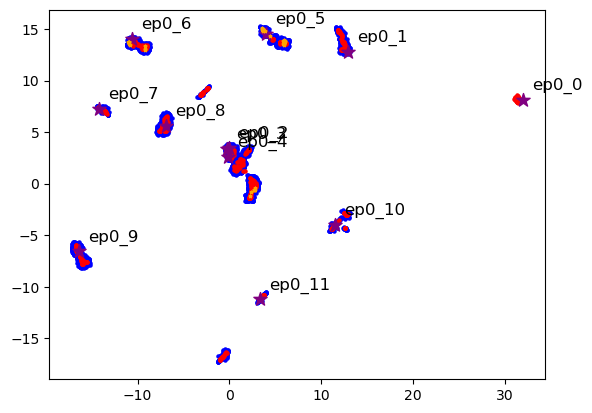

In [57]:
plt.scatter(target_emb[:, 0], target_emb[:, 1], s=5, c="b", label="Target")
plt.scatter(res.embedding_[:, 0], res.embedding_[:, 1], s=5, c="r", label="Next")

for i in range(len(ep0_emb)):
    plt.scatter(ep0_emb[i, 0], ep0_emb[i, 1], s=100, c="purple", marker="*", label="ep0")
    plt.text(ep0_emb[i, 0]+1, ep0_emb[i, 1]+1, f"ep0_{i}", fontsize=12)

plt.scatter(qpos_after_stuck_emb[:, 0], qpos_after_stuck_emb[:, 1], s=5, c="orange", marker="*", label="After stuck")

plt.show()